# 04. Data Cleansing

This notebook focuses on comprehensive **data cleansing** of the extracted article DataFrame obtained from PubMed, along with the enriched data from CrossRef's two additional columns. The script further enhances the DataFrame by incorporating two new essential columns: 'first_author' and 'last_author,' providing insights into the first and last authors of each article, respectively.

In [1]:
# Libraries Importation
import sys
import ast
import pandas as pd

# and Functions
sys.path.append('../py')
from src import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
articles = pd.read_csv('../data/pubmed_articles_raw.csv')

In [3]:
articles.head(2)

,DOI,title,authors,affiliations,journal,year,month,volume,first_page,last_page,PMID,PMCID,abstract
0,10.1177/17585732221102399,Surgical management of the spastic elbow,"['Weisang Luo 1 ', ' Matthew Nixon 1 2']","['Countess of Chester Hospital, Chester, UK.',...",Shoulder Elbow,2023,Oct,15(5),534,543,37811394,PMC10557929,['Background: We performed a retrospective rev...
1,10.1007/s11571-022-09871-6,Three-dimensional memristive Morris-Lecar mode...,"['Han Bao 1 ', ' Xihong Yu 1 ', ' Quan Xu 1...","[""School of Microelectronics and Control Engin...",Cogn Neurodyn,2023,Aug,17(4),1079,1092,37522038,PMC10374513,['To characterize the magnetic induction flow ...


In [4]:
articles.shape

(926, 13)

___

### Insert the CrossRef columns:

In [7]:
cross_ref = pd.read_csv('../data/cross_ref')

In [9]:
cross_ref.head(2)

,href,json_href
0,https://doi.org/10.1177/17585732221102399,https://api.crossref.org/works/10.1177/1758573...
1,https://doi.org/10.1007/s11571-022-09871-6,https://api.crossref.org/works/10.1007/s11571-...


In [13]:
cross_ref.shape

(926, 2)

In [16]:
articles['href'] = cross_ref['href']
articles['json_href'] = cross_ref['json_href']

In [17]:
articles.shape

(926, 15)

___

### Data cleansing protocol for the DataFrame:

    01. remove empty space from column names and cells:
    remove_spaces_column_names(df);
    remove_spaces_columns(df);

    02. Find duplicates and remove them if needed:
    any_duplicate(df)
    specific_duplicates(df, col1, col2)
    drop_duplicates(df)

    03. Find NaN values and visualize them.
    nan(df) 
    view_nan(df) 

    04. Check the columns that are constant or present low variance:
    low_variance(df) 
    unique_values(df)
    constant_columns(df)

    * Evaluate if the constant or low variance columns are needed or can be droped:
    df.drop('column', axis = 1, inplace = True)

    05. Find cells containing special characters:
    find_special_chars(df, patron = r'[?¿*$%&]')

    06. export the clean table as csv:
    df.to_csv('../output_clean/df.csv', index = False)

In [18]:
# Remove spaces drom the column names and over the columns
remove_spaces_column_names(articles);
remove_spaces_columns(articles);

In [19]:
# Search for duplicates
any_duplicate(articles)

True

In [20]:
drop_duplicates(articles)
articles.shape

(783, 15)

In [24]:
# Search NaN values
nan(articles).head()

last_page    454
volume       238
href          40
json_href     40
DOI            0
dtype: int64

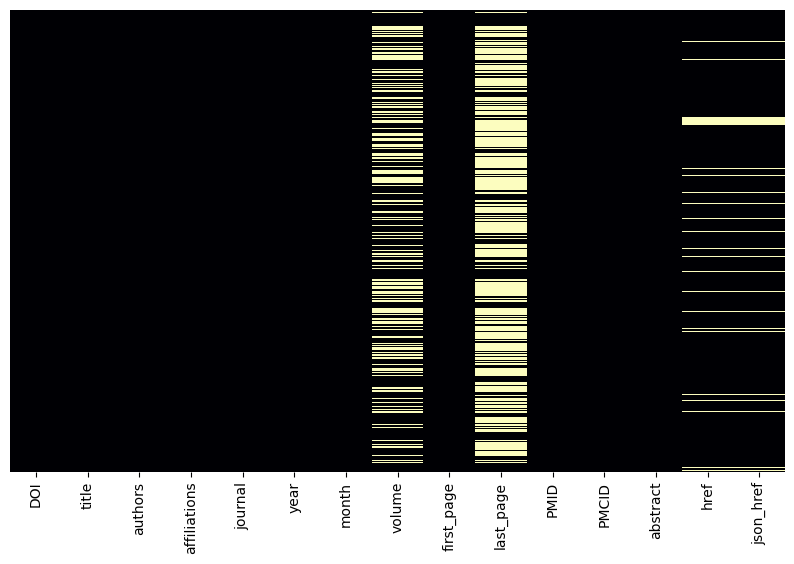

In [25]:
view_nan(articles) 

In [26]:
# There are NaN values in two columns: 
# volumnes and last_page.
# This is because the absence of protocol 
# form in the article source

articles['first_page'].value_counts()

25        8
193       8
232       5
202       5
ENEURO    5
         ..
1740      1
e428      1
e430      1
553       1
86        1
Name: first_page, Length: 685, dtype: int64

In [27]:
bad_results = {'article_source': [], 
               'index': []}

bad_res = articles['first_page'].str.split("\n").tolist()

for i, res in enumerate(bad_res):
    if len(res) > 1:
        bad_results['article_source'].append(res)
        bad_results['index'].append(i)
    else:
        continue

In [28]:
bad_results_df = pd.DataFrame(bad_results)
bad_results_df.head(2)

,article_source,index
0,"[Neurosci Res, . 2023 Jun:191:48-56.]",4
1,"[Int J Biol Macromol, . 2023 Jan 31:226:90-101.]",28


In [29]:
# I need to extract the information from 'first_page' 
# to feed 'volumne' and 'last_page'
# and maintain just the good value in 'first_page' 

for i in range(228):

    article_source = bad_results_df['article_source'][i][-1]

    # Using Regex to find the value in between ':' for volume
    match_vol = re.search(r"^(.*):(.*):(.*)$", article_source)

    # Si se encuentra un valor, lo agrega a la nueva columna
    if match_vol:
        bad_results_df.loc[i, 'volumes'] = match_vol.group(2)
        
        try:
            bad_results_df.loc[i, 'first_page'] = match_vol.group(3).split('-')[0]
        except:
            continue
            
        try:    
            bad_results_df.loc[i, 'last_page'] = match_vol.group(3).split('-')[1]
        except:
            continue

            break

In [30]:
# Now, the extracteddd data from thee article source is categorized
bad_results_df.head()

,article_source,index,volumes,first_page,last_page
0,"[Neurosci Res, . 2023 Jun:191:48-56.]",4,191,48,56.
1,"[Int J Biol Macromol, . 2023 Jan 31:226:90-101.]",28,226,90,101.
2,"[Front Neurosci, . 2023 Jan 24:16:1082375.]",29,16,1082375.,NaN
3,"[Front Neurol, . 2023 Jan 17:13:1064619.]",30,13,1064619.,NaN
4,"[Front Neurosci, . 2023 Jan 16:16:1009542.]",31,16,1009542.,NaN


In [31]:
for j in range(len(bad_results_df)):
    for i in bad_results_df['index']:
        articles.loc[i, 'first_page'] = bad_results_df.loc[j, 'first_page']
        articles.loc[i, 'last_page'] = bad_results_df.loc[j, 'last_page']
        articles.loc[i, 'volume'] = bad_results_df.loc[j, 'volumes']

In [41]:
articles.head(2)

,DOI,title,authors,affiliations,journal,year,month,volume,first_page,last_page,PMID,PMCID,abstract,href,json_href
0,10.1177/17585732221102399,Surgical management of the spastic elbow,"['Weisang Luo 1 ', ' Matthew Nixon 1 2']","['Countess of Chester Hospital, Chester, UK.',...",Shoulder Elbow,2023.0,Oct,15(5),534,543,37811394.0,PMC10557929,['Background: We performed a retrospective rev...,https://doi.org/10.1177/17585732221102399,https://api.crossref.org/works/10.1177/1758573...
1,10.1007/s11571-022-09871-6,Three-dimensional memristive Morris-Lecar mode...,"['Han Bao 1 ', ' Xihong Yu 1 ', ' Quan Xu 1...","[""School of Microelectronics and Control Engin...",Cogn Neurodyn,2023.0,Aug,17(4),1079,1092,37522038.0,PMC10374513,['To characterize the magnetic induction flow ...,https://doi.org/10.1007/s11571-022-09871-6,https://api.crossref.org/works/10.1007/s11571-...


In [33]:
any_duplicate(articles)

True

In [34]:
drop_duplicates(articles)
any_duplicate(articles)

False

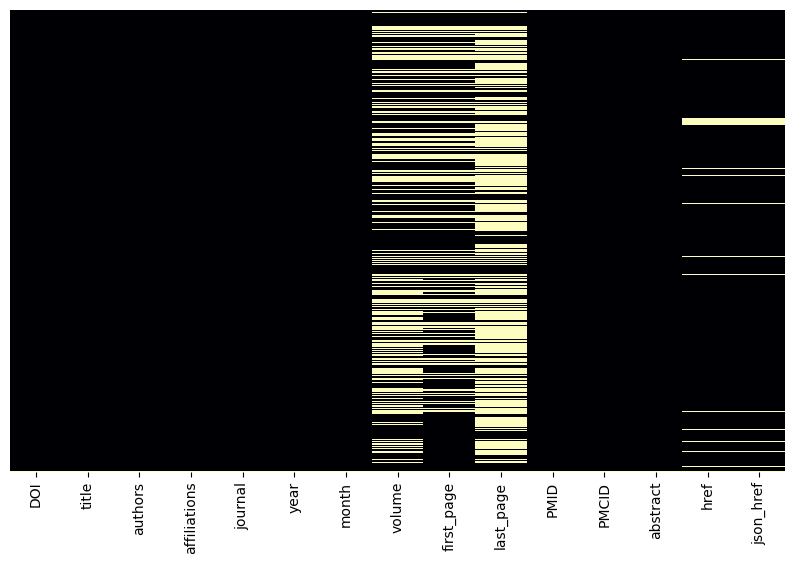

In [35]:
view_nan(articles) 

In [36]:
articles = articles.loc[articles['DOI'].notnull()]

In [37]:
articles['volume'].fillna('none', inplace = True)
articles['first_page'].fillna('none', inplace = True)
articles['last_page'].fillna('none', inplace = True)
articles['href'].fillna('none', inplace = True)
articles['json_href'].fillna('none', inplace = True)

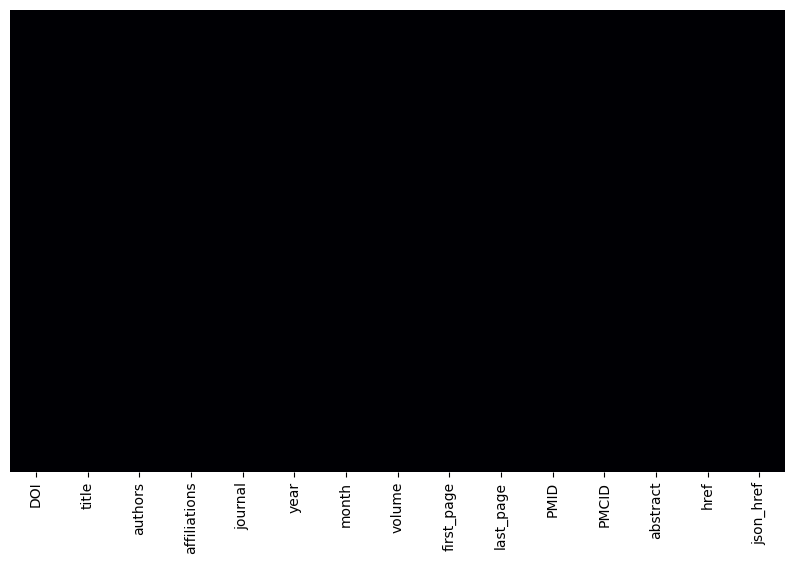

In [46]:
view_nan(articles) 

In [47]:
low_variance(articles) 

[]

In [48]:
unique_values(articles)

[('year', 3),
 ('month', 24),
 ('last_page', 252),
 ('journal', 353),
 ('volume', 357),
 ('href', 479),
 ('json_href', 479),
 ('first_page', 499),
 ('affiliations', 723),
 ('authors', 724),
 ('DOI', 726),
 ('title', 726),
 ('PMID', 726),
 ('PMCID', 726),
 ('abstract', 726)]

In [49]:
constant_columns(articles)

([], [])

In [50]:
find_special_chars(articles, patron = r'[?¿*$%&]')

In [51]:
articles = articles.reset_index(drop = True)

### Create columns: first_author and last_author

In [53]:
first_author = []
last_author = []

In [54]:
for i in range(len(articles)):
    first = ast.literal_eval(articles['authors'][i])
    last = ast.literal_eval(articles['authors'][i])
    first_author.append(first[0])
    last_author.append(last[-1])

In [55]:
articles['first_author'] = first_author
articles['last_author'] = last_author

In [56]:
articles.shape

(783, 17)

In [58]:
articles.head(2)

,DOI,title,authors,affiliations,journal,year,month,volume,first_page,last_page,PMID,PMCID,abstract,href,json_href,first_author,last_author
0,10.1177/17585732221102399,Surgical management of the spastic elbow,"['Weisang Luo 1 ', ' Matthew Nixon 1 2']","['Countess of Chester Hospital, Chester, UK.',...",Shoulder Elbow,2023.0,Oct,15(5),534,543,37811394.0,PMC10557929,['Background: We performed a retrospective rev...,https://doi.org/10.1177/17585732221102399,https://api.crossref.org/works/10.1177/1758573...,Weisang Luo 1,Matthew Nixon 1 2
1,10.1007/s11571-022-09871-6,Three-dimensional memristive Morris-Lecar mode...,"['Han Bao 1 ', ' Xihong Yu 1 ', ' Quan Xu 1...","[""School of Microelectronics and Control Engin...",Cogn Neurodyn,2023.0,Aug,17(4),1079,1092,37522038.0,PMC10374513,['To characterize the magnetic induction flow ...,https://doi.org/10.1007/s11571-022-09871-6,https://api.crossref.org/works/10.1007/s11571-...,Han Bao 1,Bocheng Bao 1


In [59]:
articles.to_csv('../data/pubmed_articles_clean.csv', index = False)